# Binary-Class Tabular Model for Kaggle Playground Series Season 3 Episode 7 Using Python and XGBoost
### David Lowe
### March 22, 2023

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Playground Series Season 3 Episode 7 dataset is a binary-class modeling situation where we attempt to predict one of two possible outcomes.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions to give the Kaggle community a variety of reasonably lightweight challenges that can be used to learn and sharpen skills in different aspects of machine learning and data science. The dataset for this competition was generated from a deep learning model trained on the Reservation Cancellation Prediction dataset. Feature distributions are close to but different from the original.

ANALYSIS: The performance of the preliminary XGBoost model achieved a ROC/AUC benchmark of 0.9099 after training. When we processed the test dataset with the final model, the model achieved a ROC/AUC score of 0.8973.

CONCLUSION: In this iteration, the XGBoost model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Playground Series Season 3, Episode 7

Dataset ML Model: Binary-Class classification with numerical features

Dataset Reference: https://www.kaggle.com/competitions/playground-series-s3e7

One source of potential performance benchmarks: https://www.kaggle.com/competitions/playground-series-s3e7/leaderboard

## Task 1 - Prepare Environment

In [1]:
# Retrieve the GPU information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Mon Mar 20 22:25:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    53W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Retrieve the memory configuration
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 89.6 gigabytes of available RAM



In [3]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 12


### 1.a) Load libraries and modules

In [4]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
import zipfile
import urllib
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier

### 1.b) Set up the controlling parameters and functions

In [6]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 2

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.1
VAL_SET_RATIO = 0.1

# Set the name for the class/label column
ORIGINAL_LABEL = 'booking_status'
CLASS_COLUMN = 'target'

# Set the number of folds for cross validation
N_FOLDS = 10

# Set default modeling scoring metric
SCORING_METRIC = 'roc_auc'

# Define the directory locations and file names
ORIGINAL_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e07/RCP_train_dataset.csv'
TRAIN_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e07/train.csv'
TEST_DATASET = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e07/test.csv'
SUBMISSION_TEMPLATE = 'https://dainesanalytics.com/datasets/kaggle-playground-series-s3e07/sample_submission.csv'
SUBMISSION_FILE = 'submission_xgboost_'

### 1.c) Load dataset

In [7]:
df_dataset_import = pd.read_csv(TRAIN_DATASET)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id  no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
0   0             2               0                     0                  2   
1   1             2               0                     1                  2   
2   2             2               0                     0                  1   
3   3             1               0                     0                  2   
4   4             2               0                     1                  0   

   type_of_meal_plan  required_car_parking_space  room_type_reserved  \
0                  1                           0                   0   
1                  0                           0                   0   
2                  0                           0                   0   
3                  1                           0                   0   
4                  0                           0                   0   

   lead_time  arrival_year  arrival_month  arrival_date  market_segment_type  \
0     

In [8]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42100 entries, 0 to 42099
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    42100 non-null  int64  
 1   no_of_adults                          42100 non-null  int64  
 2   no_of_children                        42100 non-null  int64  
 3   no_of_weekend_nights                  42100 non-null  int64  
 4   no_of_week_nights                     42100 non-null  int64  
 5   type_of_meal_plan                     42100 non-null  int64  
 6   required_car_parking_space            42100 non-null  int64  
 7   room_type_reserved                    42100 non-null  int64  
 8   lead_time                             42100 non-null  int64  
 9   arrival_year                          42100 non-null  int64  
 10  arrival_month                         42100 non-null  int64  
 11  arrival_date   

In [9]:
print(df_dataset_import.describe())

                 id  no_of_adults  no_of_children  no_of_weekend_nights  \
count  42100.000000  42100.000000    42100.000000          42100.000000   
mean   21049.500000      1.920713        0.141093              0.884632   
std    12153.367503      0.524950        0.450128              0.885693   
min        0.000000      0.000000        0.000000              0.000000   
25%    10524.750000      2.000000        0.000000              0.000000   
50%    21049.500000      2.000000        0.000000              1.000000   
75%    31574.250000      2.000000        0.000000              2.000000   
max    42099.000000      4.000000        9.000000              7.000000   

       no_of_week_nights  type_of_meal_plan  required_car_parking_space  \
count       42100.000000       42100.000000                42100.000000   
mean            2.398005           0.239192                    0.025249   
std             1.427330           0.587674                    0.156884   
min             0.000000

In [10]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id                                      0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64
Total number of NaN in the dataframe:  0


In [11]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(ORIGINAL_LABEL).size())

booking_status
0    25596
1    16504
dtype: int64


### 1.d) Data Cleaning

In [12]:
# Fetch the original dataset and use it to supplement the training
df_dataset_original = pd.read_csv(ORIGINAL_DATASET)
df_dataset_original.drop(columns=['arrival_year','arrival_month',
                                  'arrival_date'], inplace=True)
df_dataset_original['is_synthetic'] = 0

df_dataset_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18137 entries, 0 to 18136
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          18137 non-null  int64  
 1   no_of_children                        18137 non-null  int64  
 2   no_of_weekend_nights                  18137 non-null  int64  
 3   no_of_week_nights                     18137 non-null  int64  
 4   type_of_meal_plan                     18137 non-null  int64  
 5   required_car_parking_space            18137 non-null  int64  
 6   room_type_reserved                    18137 non-null  int64  
 7   lead_time                             18137 non-null  int64  
 8   market_segment_type                   18137 non-null  int64  
 9   repeated_guest                        18137 non-null  int64  
 10  no_of_previous_cancellations          18137 non-null  int64  
 11  no_of_previous_

In [13]:
# Combine the original and synthetic datasets into one training dataset
df_dataset_import['is_synthetic'] = 1
df_dataset_import.drop(columns=['id','arrival_year','arrival_month',
                                'arrival_date'], inplace=True)
df_dataset_import = pd.concat([df_dataset_import, df_dataset_original],
                              ignore_index=True)

df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60237 entries, 0 to 60236
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          60237 non-null  int64  
 1   no_of_children                        60237 non-null  int64  
 2   no_of_weekend_nights                  60237 non-null  int64  
 3   no_of_week_nights                     60237 non-null  int64  
 4   type_of_meal_plan                     60237 non-null  int64  
 5   required_car_parking_space            60237 non-null  int64  
 6   room_type_reserved                    60237 non-null  int64  
 7   lead_time                             60237 non-null  int64  
 8   market_segment_type                   60237 non-null  int64  
 9   repeated_guest                        60237 non-null  int64  
 10  no_of_previous_cancellations          60237 non-null  int64  
 11  no_of_previous_

In [14]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={ORIGINAL_LABEL: CLASS_COLUMN})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())
print(df_dataset_import.tail())

   no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
0             2               0                     0                  2   
1             2               0                     1                  2   
2             2               0                     0                  1   
3             1               0                     0                  2   
4             2               0                     1                  0   

   type_of_meal_plan  required_car_parking_space  room_type_reserved  \
0                  1                           0                   0   
1                  0                           0                   0   
2                  0                           0                   0   
3                  1                           0                   0   
4                  0                           0                   0   

   lead_time  market_segment_type  repeated_guest  \
0          9                    1               1   
1   

In [15]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60237 entries, 0 to 60236
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          60237 non-null  int64  
 1   no_of_children                        60237 non-null  int64  
 2   no_of_weekend_nights                  60237 non-null  int64  
 3   no_of_week_nights                     60237 non-null  int64  
 4   type_of_meal_plan                     60237 non-null  int64  
 5   required_car_parking_space            60237 non-null  int64  
 6   room_type_reserved                    60237 non-null  int64  
 7   lead_time                             60237 non-null  int64  
 8   market_segment_type                   60237 non-null  int64  
 9   repeated_guest                        60237 non-null  int64  
 10  no_of_previous_cancellations          60237 non-null  int64  
 11  no_of_previous_

In [16]:
print(df_dataset_import.describe())

       no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
count  60237.000000    60237.000000          60237.000000       60237.000000   
mean       1.898451        0.130983              0.862493           2.341086   
std        0.523373        0.438391              0.882668           1.429660   
min        0.000000        0.000000              0.000000           0.000000   
25%        2.000000        0.000000              0.000000           1.000000   
50%        2.000000        0.000000              1.000000           2.000000   
75%        2.000000        0.000000              2.000000           3.000000   
max        4.000000        9.000000              7.000000          17.000000   

       type_of_meal_plan  required_car_parking_space  room_type_reserved  \
count       60237.000000                60237.000000        60237.000000   
mean            0.263061                    0.027176            0.401182   
std             0.601555                    0.16259

In [17]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
target                                  0
is_synthetic                            0
dtype: int64
Total number of NaN in the dataframe:  0


In [18]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(CLASS_COLUMN).size())

target
0    37791
1    22446
dtype: int64


### 1.e) Splitting Data into Sets

In [19]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (60237, 16) df_features_train.shape: (60237, 15) df_target_train.shape: (60237,)


### 1.f) Set up the parameters for data visualization

In [20]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

## Task 2 - Summarize and Visualize Data

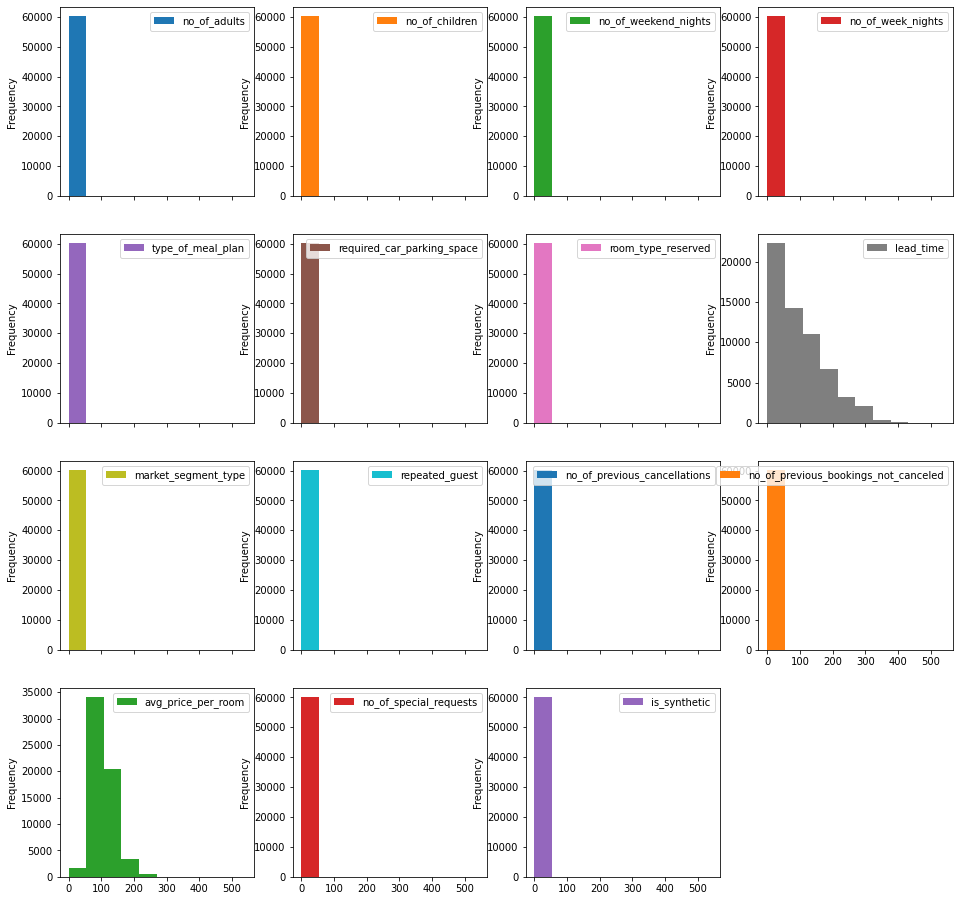

In [21]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

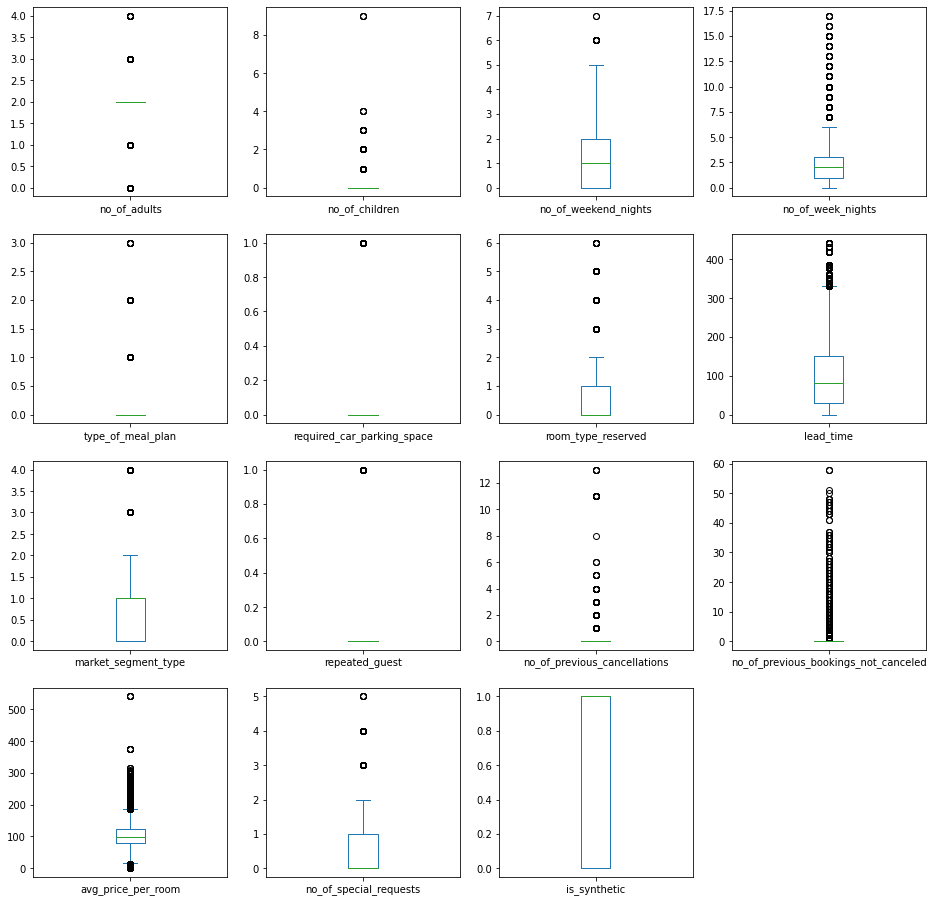

In [22]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

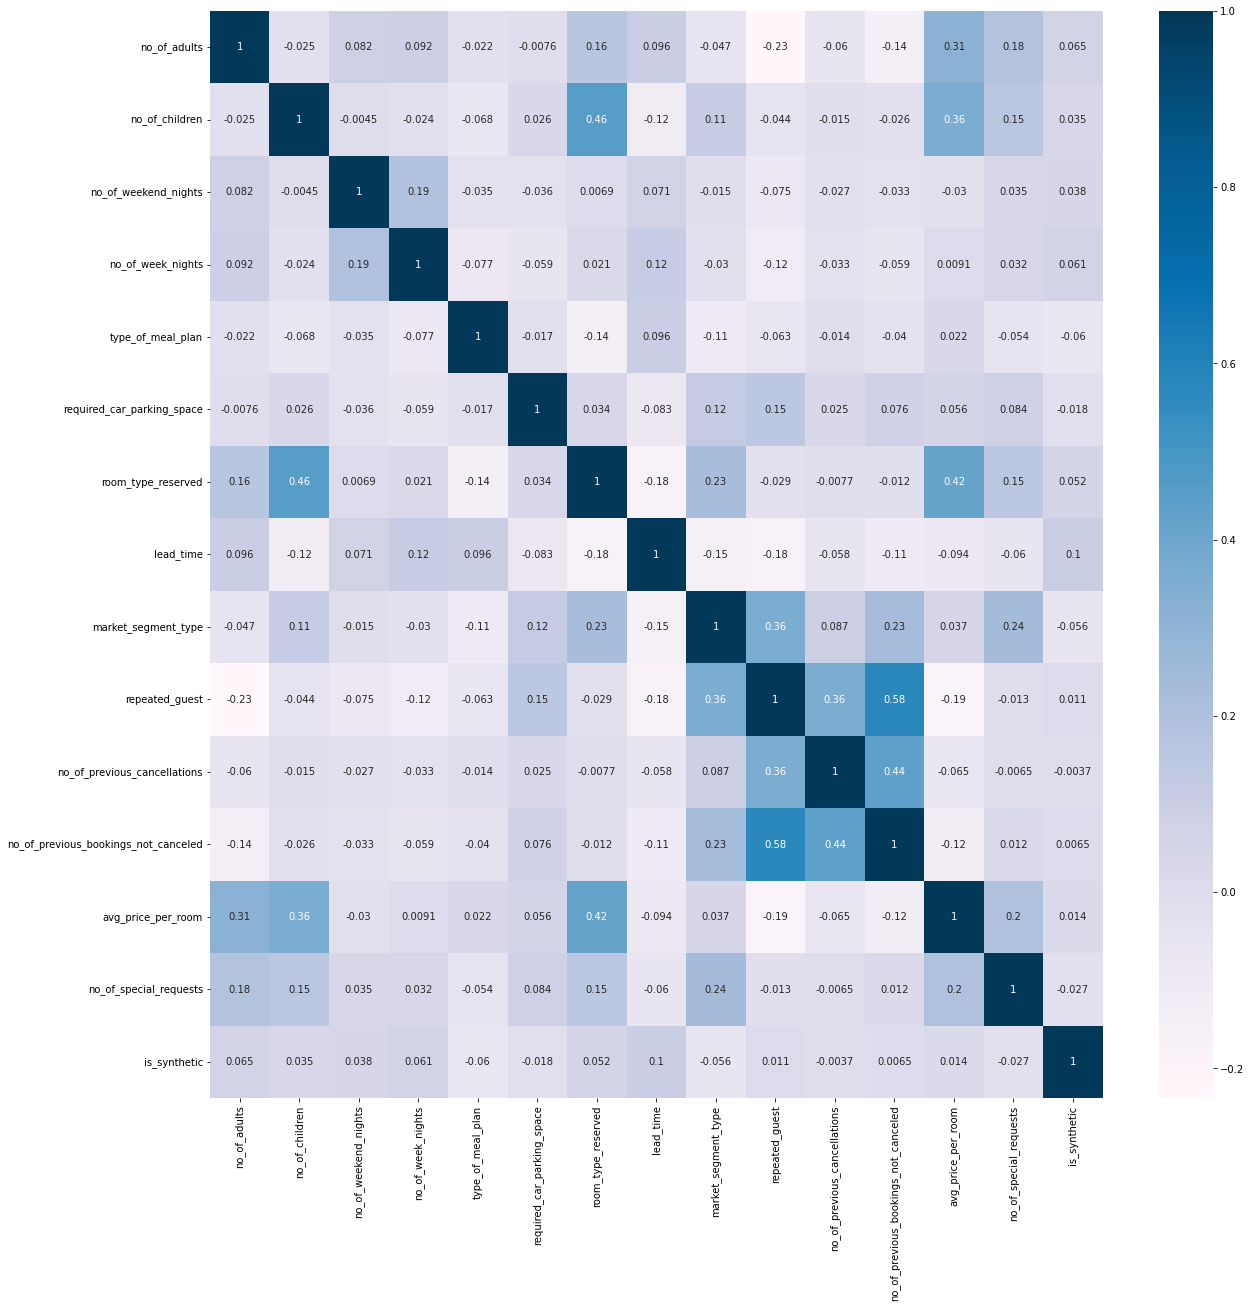

In [23]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

## Task 3 - Pre-process Data

### 3.a) Feature Scaling

In [24]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['float','int']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="median")),
    ('scaler', preprocessing.StandardScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 15
Number of categorical columns: 0
Total number of columns in the feature dataframe: 15


In [25]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
    ], remainder='passthrough')

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (60237, 15) to array_features_train.shape: (60237, 15)


In [26]:
# Finalize the training dataset for the modeling activities
array_features_train = preprocessor.fit_transform(df_features_train)
array_target_train = df_target_train.to_numpy()
# label_encoder = preprocessing.LabelEncoder()
# array_target_train = label_encoder.fit_transform(df_target_train)

### 3.b) Training Data Balancing

In [27]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [28]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [29]:
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (60237, 15) array_target_train.shape: (60237,)


## Task 4 - Train and Tune Models

### 4.a) Set test options and evaluation metric

In [30]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []

In [31]:
train_models.append(('XGB', XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', eval_metric='logloss', tree_method='gpu_hist')))

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [32]:
# Generate model in turn
for name, model in train_models:
    start_time_module = datetime.now()
    kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
    cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
    train_results.append(cv_results)
    train_model_names.append(name)
    train_metrics.append(cv_results.mean())
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
    print(model)
    print ('Model training time:', (datetime.now() - start_time_module), '\n')
print('Average metrics (' + SCORING_METRIC + ') from all models:', np.mean(train_metrics))
print('Total training time for all models:', (datetime.now() - start_time_training))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGB: 0.907448 (0.004207)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=2,
              num_parallel_tree=None, predictor=None, random_state=888, ...)
Model training time: 0:00:06.876715 

Average metrics (roc_auc) from all models: 0.907447737906925
Total training time for all models: 0:00:06.893674


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    6.8s finished


### 4.b) Algorithm Tuning

In [33]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [34]:
# Tuning XGBoost n_estimators, max_depth, and min_child_weight parameters
start_time_Module = datetime.now()
tune_model1 = XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', eval_metric='logloss', tree_method='gpu_hist')
tune_model_names.append('XGB_1')
paramGrid1 = dict(n_estimators=range(100, 501, 100),
                  max_depth=np.array([3, 6, 9]),
                  min_child_weight=np.array([1, 2, 3]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print('Model training time:', (datetime.now() - start_time_Module))

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 10 folds for each of 45 candidates, totalling 450 fits
Best: 0.909939 using {'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 200}
0.894035 (0.004641) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
0.900338 (0.004473) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
0.903043 (0.004052) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}
0.904475 (0.004065) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 400}
0.905392 (0.003915) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500}
0.893792 (0.004719) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100}
0.900486 (0.004366) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200}
0.902866 (0.004231) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300}
0.904513 (0.004263) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 400}
0.905354 (0.004271) with: {'max_depth': 3, 'min_child_weight': 2, 'n_est

In [35]:
BEST_MAX_DEPTH = grid_result1.best_params_['max_depth']
BEST_MIN_CHILD_WEIGHT = grid_result1.best_params_['min_child_weight']
BEST_N_ESTIMATORS = grid_result1.best_params_['n_estimators']
print('Best max_depth parameter:', BEST_MAX_DEPTH)
print('Best min_child_weight parameter:', BEST_MIN_CHILD_WEIGHT)
print('Best n_estimators parameter:', BEST_N_ESTIMATORS)

Best max_depth parameter: 6
Best min_child_weight parameter: 2
Best n_estimators parameter: 200


In [36]:
# Tuning XGBoost subsample and colsample_bytree parameters
start_time_Module = datetime.now()
tune_model2 = XGBClassifier(n_estimators=BEST_N_ESTIMATORS, max_depth=BEST_MAX_DEPTH, min_child_weight=BEST_MIN_CHILD_WEIGHT,
                            random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', eval_metric='logloss', tree_method='gpu_hist')
tune_model_names.append('XGB_2')
paramGrid2 = dict(subsample=np.array([0.7, 0.8, 0.9, 1.0]),
                  colsample_bytree=np.array([0.7, 0.8, 0.9, 1.0]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print('Model training time:',(datetime.now() - start_time_Module))

Fitting 10 folds for each of 16 candidates, totalling 160 fits


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Best: 0.909939 using {'colsample_bytree': 1.0, 'subsample': 1.0}
0.908323 (0.003745) with: {'colsample_bytree': 0.7, 'subsample': 0.7}
0.908589 (0.003732) with: {'colsample_bytree': 0.7, 'subsample': 0.8}
0.909398 (0.003830) with: {'colsample_bytree': 0.7, 'subsample': 0.9}
0.909692 (0.003639) with: {'colsample_bytree': 0.7, 'subsample': 1.0}
0.908399 (0.003439) with: {'colsample_bytree': 0.8, 'subsample': 0.7}
0.908812 (0.003712) with: {'colsample_bytree': 0.8, 'subsample': 0.8}
0.909423 (0.003566) with: {'colsample_bytree': 0.8, 'subsample': 0.9}
0.909918 (0.003768) with: {'colsample_bytree': 0.8, 'subsample': 1.0}
0.908510 (0.004129) with: {'colsample_bytree': 0.9, 'subsample': 0.7}
0.908879 (0.003979) with: {'colsample_bytree': 0.9, 'subsample': 0.8}
0.909453 (0.003422) with: {'colsample_bytree': 0.9, 'subsample': 0.9}
0.909910 (0.003776) with: {'colsample_bytree': 0.9, 'subsample': 1.0}
0.907748 (0.003474) with: {'colsample_bytree': 1.0, 'subsample': 0.7}
0.907724 (0.003646) with:

In [37]:
BEST_COLSAMPLE_BYTREE = grid_result2.best_params_['colsample_bytree']
BEST_SUBSAMPLE = grid_result2.best_params_['subsample']
print('Best colsample_bytree parameter:', BEST_COLSAMPLE_BYTREE)
print('Best subsample parameter:', BEST_SUBSAMPLE)

Best colsample_bytree parameter: 1.0
Best subsample parameter: 1.0


### 4.c) Compare Algorithms After Tuning

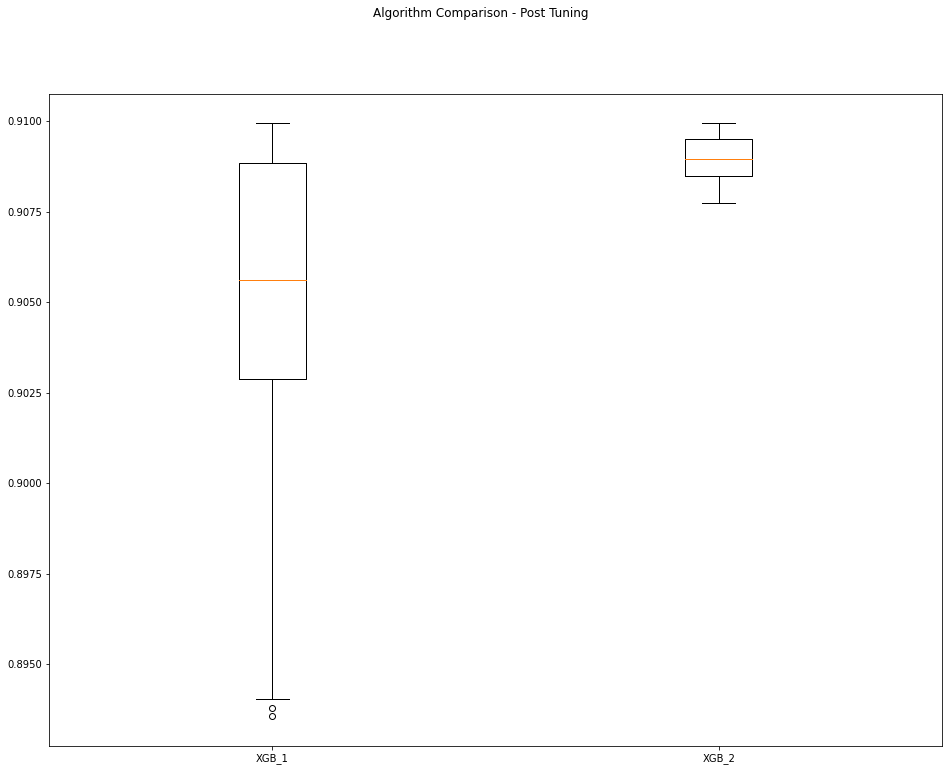

In [38]:
fig = plt.figure(figsize=(16, 12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

## Task 5 - Finalize Model and Make Predictions

### 5.a) Train the Final Model

In [39]:
final_model = XGBClassifier(n_estimators=BEST_N_ESTIMATORS, max_depth=BEST_MAX_DEPTH, min_child_weight=BEST_MIN_CHILD_WEIGHT,
                            colsample_bytree=BEST_COLSAMPLE_BYTREE, subsample=BEST_SUBSAMPLE, random_state=RNG_SEED,
                            n_jobs=N_JOBS, objective='binary:logistic', eval_metric='logloss', tree_method='gpu_hist')
final_model.fit(array_features_train, array_target_train)
print(final_model)

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=2,
              num_parallel_tree=None, predictor=None, random_state=888, ...)


### 5.b) Load Test Dataset and Make Predictions

In [40]:
df_features_test = pd.read_csv(TEST_DATASET)
df_features_test['is_synthetic'] = 1
df_features_test.drop(columns=['arrival_year','arrival_month',
                               'arrival_date'], inplace=True)

df_features_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28068 entries, 0 to 28067
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    28068 non-null  int64  
 1   no_of_adults                          28068 non-null  int64  
 2   no_of_children                        28068 non-null  int64  
 3   no_of_weekend_nights                  28068 non-null  int64  
 4   no_of_week_nights                     28068 non-null  int64  
 5   type_of_meal_plan                     28068 non-null  int64  
 6   required_car_parking_space            28068 non-null  int64  
 7   room_type_reserved                    28068 non-null  int64  
 8   lead_time                             28068 non-null  int64  
 9   market_segment_type                   28068 non-null  int64  
 10  repeated_guest                        28068 non-null  int64  
 11  no_of_previous_

In [41]:
id_column_name = df_features_test.columns[0]
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission[id_column_name] = df_features_test[id_column_name]
print(df_kaggle_submission.head())

      id
0  42100
1  42101
2  42102
3  42103
4  42104


In [42]:
# Dropping unique identifier and unnecessary features
df_features_test.drop(columns=[id_column_name,], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

   no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
0             3               0                     1                  4   
1             2               0                     0                  3   
2             2               2                     0                  1   
3             2               0                     0                  3   
4             1               0                     0                  2   

   type_of_meal_plan  required_car_parking_space  room_type_reserved  \
0                  0                           0                   1   
1                  0                           0                   0   
2                  0                           0                   3   
3                  0                           0                   0   
4                  2                           0                   0   

   lead_time  market_segment_type  repeated_guest  \
0        111                    1               0   
1   

In [43]:
# Finalize the test dataset for the testing activities
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (28068, 15) to array_features_test.shape: (28068, 15)


In [44]:
# Make batched predictions
test_predictions =  final_model.predict_proba(array_features_test)
print(test_predictions)

[[0.7904177  0.2095823 ]
 [0.77131104 0.22868893]
 [0.78543055 0.21456942]
 ...
 [0.9121633  0.08783669]
 [0.4528063  0.5471937 ]
 [0.06013173 0.9398683 ]]


In [45]:
df_sample_submission = pd.read_csv(SUBMISSION_TEMPLATE)
df_sample_submission.drop(columns=[id_column_name], inplace=True)
submission_header = list(df_sample_submission.columns)[0]
print(submission_header)

booking_status


In [46]:
df_kaggle_submission[submission_header] = test_predictions[:,1]
print(df_kaggle_submission.head())

      id  booking_status
0  42100        0.209582
1  42101        0.228689
2  42102        0.214569
3  42103        0.018865
4  42104        0.485544


In [47]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = SUBMISSION_FILE + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_xgboost_20230320-2243.csv


In [48]:
print ('Total time for the script:', (datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:17:40.789596
